In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
print ("pandas version:  {}".format(pd.__version__))
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance

print("XGBoost version:  {}".format(xgb.__version__))

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

pandas version:  2.0.3
XGBoost version:  2.0.1
/kaggle/input/storesalestfs-featureenigneering/__results__.html
/kaggle/input/storesalestfs-featureenigneering/__notebook__.ipynb
/kaggle/input/storesalestfs-featureenigneering/__output__.json
/kaggle/input/storesalestfs-featureenigneering/train_features.csv
/kaggle/input/storesalestfs-featureenigneering/test_features.csv
/kaggle/input/storesalestfs-featureenigneering/custom.css
/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
# read the output file of the prepare data notebook here
train = pd.read_csv('/kaggle/input/storesalestfs-featureenigneering/train_features.csv')
test = pd.read_csv('/kaggle/input/storesalestfs-featureenigneering/test_features.csv')
# and sample submission
sample_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

In [3]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,...,c_sales_std,is_onpromotion,op_sales_median,op_sales_mean,op_sales_min,op_sales_max,dcoilwtico,is_national_hol,is_local_hol,is_holiday
0,648648,2014-01-01,1,AUTOMOTIVE,0.0,0,2014,1,1,2,...,6.250549,0,3.0,3.542113,0.0,19.0,98.17,True,False,True
1,648649,2014-01-01,1,BABY CARE,0.0,0,2014,1,1,2,...,0.766963,0,0.0,0.000000,0.0,0.0,98.17,True,False,True
2,648650,2014-01-01,1,BEAUTY,0.0,0,2014,1,1,2,...,5.110346,0,2.0,2.263397,0.0,11.0,98.17,True,False,True
3,648651,2014-01-01,1,BEVERAGES,0.0,0,2014,1,1,2,...,2431.441640,0,1093.0,1266.943522,0.0,3366.0,98.17,True,False,True
4,648652,2014-01-01,1,BOOKS,0.0,0,2014,1,1,2,...,0.618165,0,0.0,0.159848,0.0,8.0,98.17,True,False,True


In [4]:
test.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,dayofweek,...,c_sales_std,is_onpromotion,op_sales_median,op_sales_mean,op_sales_min,op_sales_max,dcoilwtico,is_national_hol,is_local_hol,is_holiday
0,3000888,2017-08-16,1,AUTOMOTIVE,0.0,0,2017,8,16,2,...,6.250549,0,3.0,3.542113,0.0,19.0,46.8,False,False,False
1,3000889,2017-08-16,1,BABY CARE,0.0,0,2017,8,16,2,...,0.766963,0,0.0,0.000000,0.0,0.0,46.8,False,False,False
2,3000890,2017-08-16,1,BEAUTY,0.0,2,2017,8,16,2,...,5.110346,1,4.0,4.173516,1.0,12.0,46.8,False,False,False
3,3000891,2017-08-16,1,BEVERAGES,0.0,20,2017,8,16,2,...,2431.441640,1,2097.0,1942.677134,325.0,5051.0,46.8,False,False,False
4,3000892,2017-08-16,1,BOOKS,0.0,0,2017,8,16,2,...,0.618165,0,0.0,0.159848,0.0,8.0,46.8,False,False,False


In [5]:
# append train and test temporarily
train = pd.concat( [train,test])

In [6]:
train.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
year                 0
month                0
day                  0
dayofweek            0
dayofyear            0
weekofyear           0
is_weekend           0
weekIdContinous      0
sales_lag2w          0
sales_lag4w          0
sales_lag8w          0
sales_lag1y          0
is_payday            0
sf_monthly_mean      0
sf_yearly_mean       0
s_sales_median       0
s_sales_mean         0
s_sales_max          0
s_sales_std          0
city                 0
state                0
type                 0
cluster              0
transactions_mean    0
transactions_std     0
st_ratio             0
c_sales_median       0
c_sales_mean         0
c_sales_max          0
c_sales_std          0
is_onpromotion       0
op_sales_median      0
op_sales_mean        0
op_sales_min         0
op_sales_max         0
dcoilwtico           0
is_national_hol      0
is_local_ho

In [7]:
# skipped, led to worse results
#categorical_columns = ['store_nbr', 'cluster' , 'type', 'city', 'state' , 'family']
# Convert categorical columns to category type
#for col in categorical_columns:
#    train[col] = train[col].astype('category')

In [8]:
train.dtypes

id                     int64
date                  object
store_nbr              int64
family                object
sales                float64
onpromotion            int64
year                   int64
month                  int64
day                    int64
dayofweek              int64
dayofyear              int64
weekofyear             int64
is_weekend              bool
weekIdContinous        int64
sales_lag2w          float64
sales_lag4w          float64
sales_lag8w          float64
sales_lag1y          float64
is_payday              int64
sf_monthly_mean      float64
sf_yearly_mean       float64
s_sales_median       float64
s_sales_mean         float64
s_sales_max          float64
s_sales_std          float64
city                  object
state                 object
type                  object
cluster                int64
transactions_mean    float64
transactions_std     float64
st_ratio             float64
c_sales_median       float64
c_sales_mean         float64
c_sales_max   

# Label Encoding

In [9]:
label_encoder = LabelEncoder()

train.city = label_encoder.fit_transform(train.city)
train.state = label_encoder.fit_transform(train.state)
train.cluster = label_encoder.fit_transform(train.cluster)
train.type = label_encoder.fit_transform(train.type)
train.family = label_encoder.fit_transform(train.family)
train.is_national_hol = label_encoder.fit_transform(train.is_national_hol)
train.is_local_hol = label_encoder.fit_transform(train.is_local_hol)
train.is_holiday = label_encoder.fit_transform(train.is_holiday)
train.is_weekend = label_encoder.fit_transform(train.is_weekend)
train.dtypes

id                     int64
date                  object
store_nbr              int64
family                 int64
sales                float64
onpromotion            int64
year                   int64
month                  int64
day                    int64
dayofweek              int64
dayofyear              int64
weekofyear             int64
is_weekend             int64
weekIdContinous        int64
sales_lag2w          float64
sales_lag4w          float64
sales_lag8w          float64
sales_lag1y          float64
is_payday              int64
sf_monthly_mean      float64
sf_yearly_mean       float64
s_sales_median       float64
s_sales_mean         float64
s_sales_max          float64
s_sales_std          float64
city                   int64
state                  int64
type                   int64
cluster                int64
transactions_mean    float64
transactions_std     float64
st_ratio             float64
c_sales_median       float64
c_sales_mean         float64
c_sales_max   

In [10]:
# convert whole numbers to smaller data type 
train.store_nbr = train.store_nbr.astype('int8')
train.month = train.month.astype('int8')
train.day = train.day.astype('int8')
train.weekofyear = train.weekofyear.astype('int8')
train.dayofyear = train.dayofyear.astype('int16')
train.year = train.year.astype('int16')
train.family = train.family.astype('int8')
train.onpromotion = train.onpromotion.astype('int16')
train.is_onpromotion = train.is_onpromotion.astype('int8')
train.dayofweek = train.dayofweek.astype('int8')
train.city = train.city.astype('int8')
train.state = train.state.astype('int8')
train.type = train.type.astype('int8')
train.cluster = train.cluster.astype('int8')
train.is_national_hol = train.is_national_hol.astype('int8')
train.is_local_hol = train.is_local_hol.astype('int8')
train.is_holiday = train.is_holiday.astype('int8')
train.is_weekend = train.is_weekend.astype('int8')
train.is_payday = train.is_payday.astype('int8')
train.dcoilwtico = train.dcoilwtico.astype('float32')

In [11]:
# Convert categorical columns to category type again, this info got lost
#for col in categorical_columns:
#    train[col] = train[col].astype('category')

In [12]:
train.dtypes

id                     int64
date                  object
store_nbr               int8
family                  int8
sales                float64
onpromotion            int16
year                   int16
month                   int8
day                     int8
dayofweek               int8
dayofyear              int16
weekofyear              int8
is_weekend              int8
weekIdContinous        int64
sales_lag2w          float64
sales_lag4w          float64
sales_lag8w          float64
sales_lag1y          float64
is_payday               int8
sf_monthly_mean      float64
sf_yearly_mean       float64
s_sales_median       float64
s_sales_mean         float64
s_sales_max          float64
s_sales_std          float64
city                    int8
state                   int8
type                    int8
cluster                 int8
transactions_mean    float64
transactions_std     float64
st_ratio             float64
c_sales_median       float64
c_sales_mean         float64
c_sales_max   

In [13]:
correlations = train.drop(columns = ['id','date','is_national_hol','is_local_hol'],axis=1).corr()['sales']

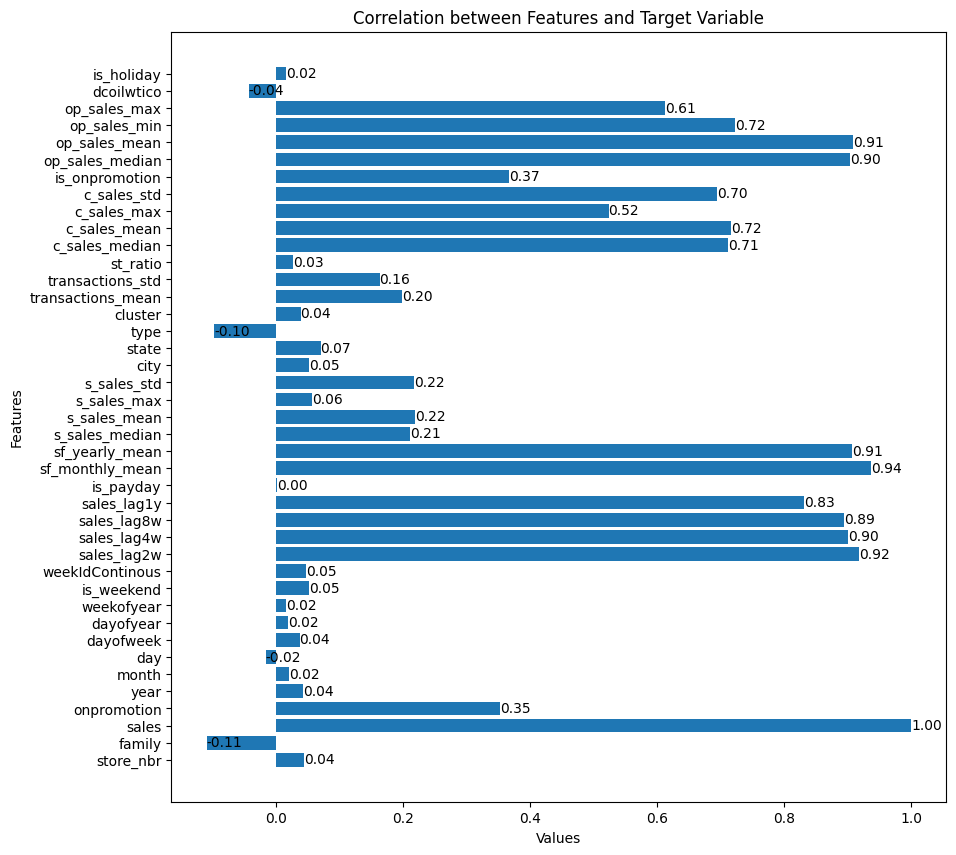

In [14]:
plt.figure(figsize=(10, 10))
bars = plt.barh(correlations.index,correlations.values)
plt.xlabel('Values')
plt.ylabel('Features')
plt.title('Correlation between Features and Target Variable')
# Add labels to the bars
for bar, value in zip(bars, correlations.values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value:.2f}', ha='left', va='center')

plt.show()

In [15]:
# split train and test again
test = train.loc[train.id >= 3000888]
test.shape

(28512, 45)

In [16]:
train = train.loc[train.id < 3000888]
train.shape

(2361414, 45)

# Model: XGBoost

In [17]:
columns_to_drop = ['sales','id','date','is_national_hol','is_local_hol']

In [18]:
# create validation set based on time, I use 2 weeks because the test set is 2 weeks
#train.date.max()
X_train = train.loc[train.date < '2017-08-01']
X_train.tail()
y_train = X_train.sales
X_train = X_train.drop(columns_to_drop, axis = 1)
X_val = train.loc[train.date >= '2017-08-01']
y_val = X_val.sales
X_val = X_val.drop(columns_to_drop, axis = 1)

In [19]:
dtrain = xgb.DMatrix(data = X_train, label = np.log1p(y_train)) 
dval = xgb.DMatrix(data = X_val, label = np.log1p(y_val))

evals = [(dtrain,'train'),(dval,'val')]

evals_result ={} # to capture eval metric during training 

In [20]:
# run with root mean squared error and log transform manually, like for lgbm. 
# Unlike, lgbm xgboost can use rmsle as metric but see warnings in xgboost documentation.
# using root mean squared log error resulted in NaNs in the eval metric.
params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        'learning_rate': 0.06918148741476102, 
        'max_depth': 12, 
        'subsample': 0.8580152069485152, 
        'colsample_bytree': 0.8523572523520506, 
        'min_child_weight': 7
}

In [21]:
ts = time.time()

model = xgb.train(params, 
                  dtrain, 
                  num_boost_round = 500, 
                  evals=evals, 
                  evals_result = evals_result, 
                  early_stopping_rounds = 50, 
                  verbose_eval = 50)

execution_time = time.time() - ts
print("\nTraining time: " + str(round(execution_time,3)) + "s")

[0]	train-rmse:2.49332	val-rmse:2.39586
[50]	train-rmse:0.37041	val-rmse:0.37842
[100]	train-rmse:0.34107	val-rmse:0.36777
[150]	train-rmse:0.32828	val-rmse:0.36568
[200]	train-rmse:0.31913	val-rmse:0.36417
[250]	train-rmse:0.31157	val-rmse:0.36459
[271]	train-rmse:0.30835	val-rmse:0.36504

Training time: 170.064s


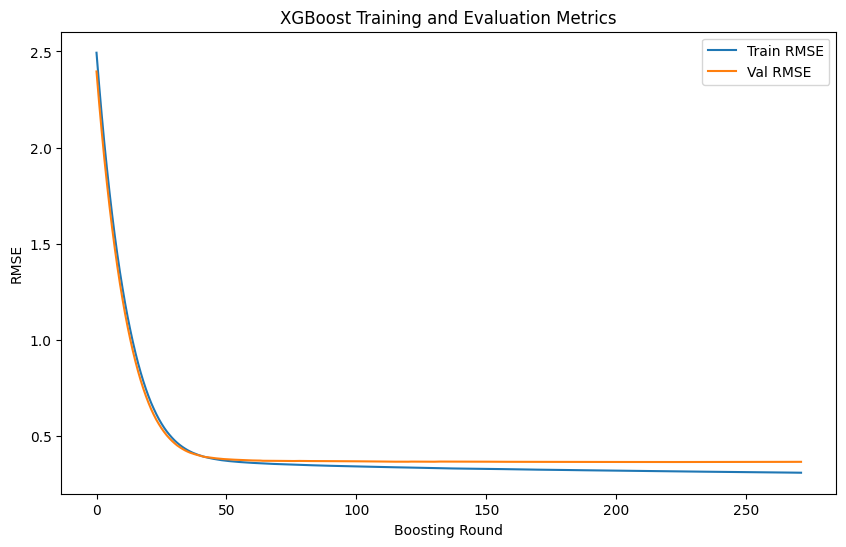

In [22]:
# Plot the training and validation metrics over boosting rounds
train_metric = evals_result['train']['rmse']
eval_metric = evals_result['val']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_metric, label='Train RMSE')
plt.plot(eval_metric, label='Val RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('XGBoost Training and Evaluation Metrics')
plt.legend()
plt.show()

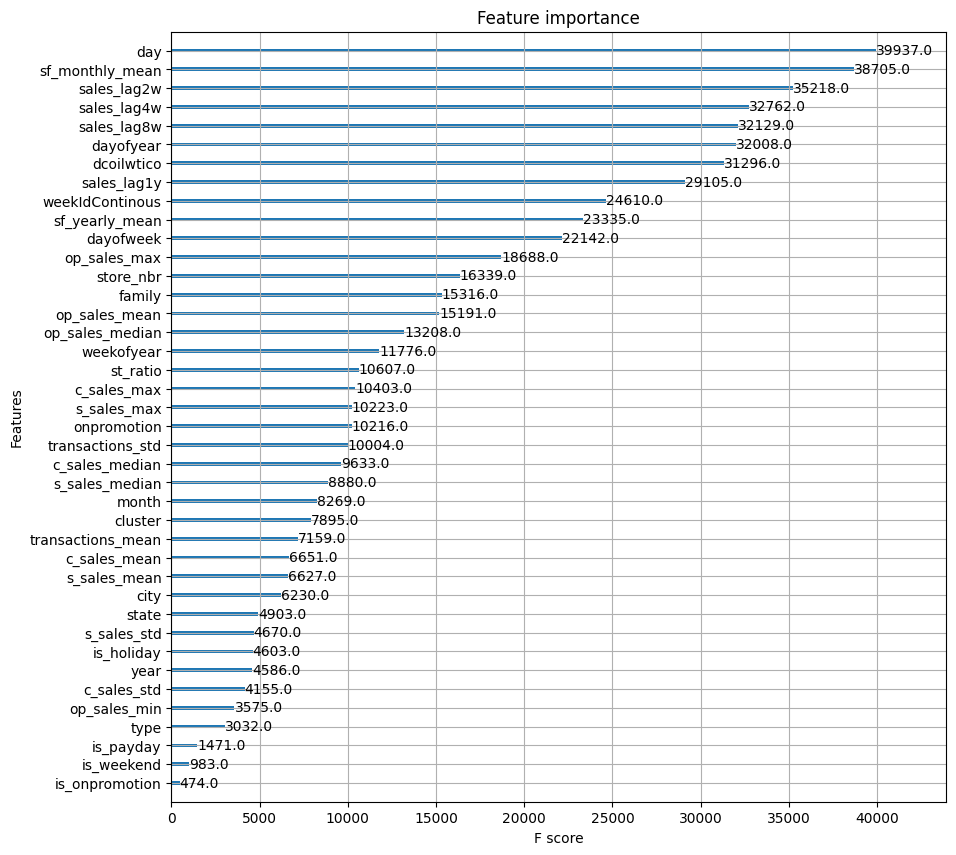

In [23]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, importance_type = "weight") #weight, gain, cover

plot_features(model,(10,10) )
plt.show()

# please read:https://forecastegy.com/posts/xgboost-feature-importance-python/  for more info!

Retrain on whole dataset

In [24]:
dtraint = xgb.DMatrix(data = train.drop(columns_to_drop, axis = 1), label = np.log1p(train.sales), enable_categorical = True) 
dtestt = xgb.DMatrix(data = test.drop(columns_to_drop, axis = 1), enable_categorical = True)

In [25]:
ts = time.time()
model = xgb.train(params, dtraint, num_boost_round = 300)

execution_time = time.time() - ts
print("\nTraining time: " + str(round(execution_time,3)) + "s")


Training time: 162.218s


In [26]:
preds = np.expm1(model.predict(dtestt)) # transform predictions back immediatelly

In [27]:
preds.min()

-0.17788889

In [28]:
preds.max()

13278.46

In [29]:
preds=preds.clip(0,20000)

# Postprocessing

In [30]:
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')

submission_pre = pd.DataFrame(data={"id" : sample_submission.id,
                                   "preds" : preds})

submission_pre = pd.merge(test,submission_pre, on='id',how='left')

# get info about which stores have 0 sales for which categories out of train
store_info=train[['store_nbr','family','sales']].groupby(['store_nbr','family']).sum().reset_index()
store_info = store_info.loc[store_info.sales == 0] #reduce to those without sales

categories_not_sold_in_all_stores = store_info.family.unique()

# set all predictions to 0 for the categories that are not sold in certain stores
for cat in categories_not_sold_in_all_stores:
    category = cat
    stores_that_dont_sell_category = list(store_info.loc[(store_info.family == category)].store_nbr)
    submission_pre.loc[submission_pre.store_nbr.isin(stores_that_dont_sell_category) & (submission_pre.family==category),['preds']] = 0
    
submission_pre.head()

,id,date,store_nbr,family,onpromotion,preds
0,3000888,2017-08-16,1,AUTOMOTIVE,0,3.890726
1,3000889,2017-08-16,1,BABY CARE,0,0.000000
2,3000890,2017-08-16,1,BEAUTY,2,5.105474
3,3000891,2017-08-16,1,BEVERAGES,20,2497.965820
4,3000892,2017-08-16,1,BOOKS,0,0.000000


# Submission

In [31]:
# generate submission file 
submission = submission_pre[['id','preds']]
submission = submission.rename(columns={'preds':'sales'})

submission.to_csv('submission.csv', index=False)
submission.head()

,id,sales
0,3000888,3.890726
1,3000889,0.000000
2,3000890,5.105474
3,3000891,2497.965820
4,3000892,0.000000
